Path Table:
 {(0, 6): [(0, 6)], (10, 2): [(10, 2)], (1, 3): [(0, 6), (1, 3)], (4, 7): [(0, 6), (1, 3), (4, 7)]}

Distance:
 {(0, 6): 3, (10, 2): 5, (1, 3): 6, (4, 7): 8}

Occurrences:
 {((0, 0), (0, 6)): '3', ((0, 0), (10, 2)): '1', ((0, 6), (1, 3)): '2', ((1, 3), (4, 7)): '1'}


<AxesSubplot:>

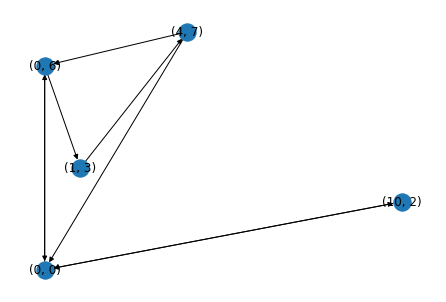

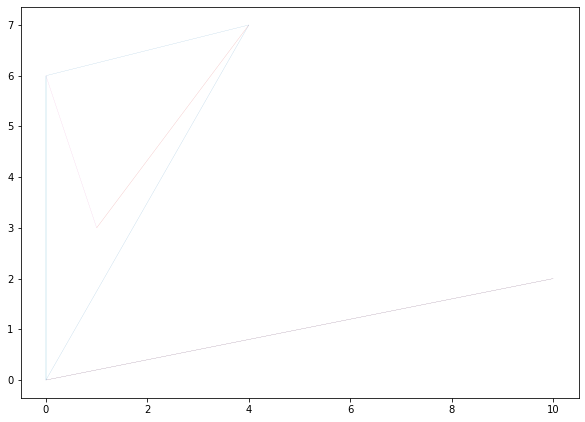

In [5]:
import networkx as nx
from matplotlib.colors import ListedColormap
import heapq
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import copy
import sys

G = nx.DiGraph()
src = (0, 0)

G.add_nodes_from([(0, 0), (1,3), (4,7), (0,6), (10,2)])
G.add_edge((0, 0), (0, 6), weight=3)
G.add_edge((0, 6), (0, 0), weight=3)
G.add_edge((0, 6), (1, 3), weight=3)
G.add_edge((0, 0), (10, 2), weight=5)
G.add_edge((10, 2), (0, 0), weight=5)
G.add_edge((1, 3), (4, 7), weight=2)
G.add_edge((4, 7), (0, 0), weight=4)
G.add_edge((4, 7), (0, 6), weight=8)

posDict = dict()
for elem in list(G.nodes):
    posDict[elem] = (elem[0], elem[1])

adjacencyTable = dict()
for elem in G.adjacency():
    if len(elem[1]) != 0:
        adjacencyTable[elem[0]] = elem[1]

#print(adjacencyTable)

pathTable = dict()
visited = set()
unvisited = set(G.nodes)
heap = []
heapq.heappush(heap, (0, src))
distance = dict()
#print(heap)

while len(heap) is not 0:
    curr = heapq.heappop(heap)
    if curr[1] in visited:
        continue
    unvisited.remove(curr[1])
    visited.add(curr[1])
    
    for neighbor in adjacencyTable.get(curr[1], []):
        if neighbor in visited:
            continue
        weight = adjacencyTable[curr[1]][neighbor]['weight'] + curr[0]

        # update distance to current node
        currDistance = distance.get(neighbor, sys.float_info.max)
        currDistance = min(currDistance, weight)
        distance[neighbor] = currDistance

        # add neighbor to queue
        heapq.heappush(heap, (weight, neighbor))
        path = pathTable.get(curr[1], [])
        path = copy.deepcopy(path)
        path.append(neighbor)
        pathTable[neighbor] = path
    
    #print(heap)

nx.draw(G, pos=posDict)
nx.draw_networkx_labels(G, pos=posDict)
print("Path Table:\n", pathTable)
print()
print("Distance:\n", distance)
print()

occurrences = dict()
for dst in pathTable:
    pathList = pathTable.get(dst, [])
    pathList.insert(0, src)
    if len(pathList) < 2:
        continue

    for i in range(len(pathList) - 1):
        amount = occurrences.get((pathList[i], pathList[i + 1]), 0)
        amount = str(int(amount) + 1)
        occurrences[(pathList[i], pathList[i + 1])] = amount

print("Occurrences:\n", occurrences)

series = []
column = []
for edge in occurrences:
    series.append(LineString([edge[0], edge[1]]))
    column.append(occurrences[edge])

for node1 in adjacencyTable:
    for node2 in adjacencyTable.get(node1, {}):
        if (node1, node2) not in occurrences:
            series.append(LineString([node1, node2]))
            column.append('0')

frame = gpd.GeoDataFrame({'visits': column, 'geometry': series})
frame.plot(figsize=(10,10), linewidth=0.1, column='visits')